# Taking a first look and cleaning the data.
* [Data Source](https://airtable.com/appeVUdmRBi3K9hTS/tblLywLvMA2OTesQP/viwRRKOaZvvkSNfmU?blocks=hide)
* [Term Explanations](https://docs.calitp.org/data-infra/datasets_and_tables/transitdatabase.html)

In [1]:
import numpy as np
import pandas as pd

pd.options.display.max_columns = 50
pd.options.display.max_rows = 250
pd.set_option("display.max_colwidth", None)
pd.options.display.float_format = "{:.2f}".format

from itertools import chain
from os import path

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from calitp import *
from PIL import Image
from siuba import *
from wordcloud import STOPWORDS, ImageColorGenerator, WordCloud

GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/transit_stacks/"

## Products Data

In [2]:
# drop columns with tons of NAs
products = (
    to_snakecase(pd.read_csv(f"{GCS_FILE_PATH}products_May_3.csv"))
    .drop(
        columns=[
            "business_model_features",
            "attachments",
            "status",
            "certifications",
            "connectivity",
            "accepted_input_components",
            "output_components",
            "input",
            "output",
        ]
    )
    .rename(columns={"name": "product_name"})
)

In [3]:
products.columns

Index(['product_name', 'components', 'vendor', 'url', 'requirements',
       'product_features', 'notes', 'organization_stack_components'],
      dtype='object')

In [4]:
products.isna().sum()

product_name                       0
components                         9
vendor                            40
url                               70
requirements                     233
product_features                 180
notes                            173
organization_stack_components    103
dtype: int64

In [5]:
### Count number of strings in organization_stack_components column to see how many orgs are using this vendor.
# https://stackoverflow.com/questions/51502263/pandas-dataframe-object-has-no-attribute-str
products["count_of_orgs_using_product"] = (
    products["organization_stack_components"]
    .str.split(",+")
    .str.len()
    .groupby(products.product_name)
    .transform("sum")
)

In [6]:
unique_vendors = products.vendor.nunique()
f"{unique_vendors} unique vendors"

'83 unique vendors'

In [7]:
f"{products.product_name.nunique()} unique products"

'259 unique products'

In [8]:
products.sample(3)

,product_name,components,vendor,url,requirements,product_features,notes,organization_stack_components,count_of_orgs_using_product
159,Cubic Mobile Suite,"Mobile trip planning app,Mobile ticketing",Cubic,https://www.cubic.com/solutions/transportation/mobile-suite,NaN,NaN,NaN,NaN,0.00
58,Genfare FastFare,Cash Farebox,Genfare,https://www.genfare.com/fare-management-solutions/genfare-link/payment-devices/,NaN,hardware,Combines traditional fare media with emerging technology providing the flexibility to expand as new technology becomes available\n\n-Seamless integration with e-Fare® web based fare system and mobile ticketing\n- Innovative design improves passenger interface and usability while providing a state-of-the-art fleet image\n- Reliability and ease of maintenance minimizes repair time and maximizes up time,NaN,0.00
182,GMV/Syncromatics Easy Rides,"On-Demand Dispatch,AVL Software",GMV Syncromatics Inc,https://gmvsyncromatics.com/paratransit-dispatch,On-board tablet or computer,Cloud-based,"Easy Rides is our comprehensive demand response software for paratransit and non-emergency medical transportation operators, campus safe rides, and other small shuttle systems. Easy Rides includes features such as automatic vehicle location tracking and electronic manifests along with advanced tools to streamline reporting, billing, and data analysis. \n\nEasy Rides goes hand-in-hand with our other technology solutions. The operator software runs on any standard Android tablet and can be installed on the same tablet as our fixed-route software, allowing for flexible dual-mode vehicle use for agencies.\n\nWe created the Easy Rides software suite to be user-friendly and fully scalable to a wide variety of paratransit and demand response services. Easy Rides is currently installed in more than 90 agencies and is continuously growing.",NaN,0.00


In [9]:
products = products.fillna("N/A")

### What % of vendors with scheduling software also provide GTFS data out of the box? DRAFT
* Go back and tag companies for GTFS.

In [10]:
# https://stackoverflow.com/questions/47125076/how-to-filter-rows-containing-specific-string-values-with-an-and-operator
gtfs_scheduling = products[
    products["components"].str.contains("GTFS")
    & products["components"].str.contains("Scheduling")
]
gtfs_scheduling[
    ["product_name", "components", "vendor", "count_of_orgs_using_product", "notes"]
]

,product_name,components,vendor,count_of_orgs_using_product,notes
128,TripShot - Unspecified,"KPI Reporting,Scheduling (Fixed-route),Scheduling (Demand-Responsive),Mobile trip planning app,Real-time info,GTFS generation",TripShot Inc.,1.00,N/A
234,Giro HASTUS,"Scheduling (Fixed-route),GTFS generation",Giro Inc.,35.00,N/A
235,The Master Scheduler,"Scheduling (Fixed-route),GTFS generation",The Master Scheduler,5.00,http://themasterscheduler.com/whitepapers/TMS2GT.pdf
236,Trapeze - Unspecified,"Scheduling (Fixed-route),GTFS generation",Trapeze Group,23.00,N/A
237,Optibus,"Scheduling (Fixed-route),GTFS Schedule Publishing,GTFS generation",Optibus,10.00,N/A


In [11]:
vendors_gtfs_scheduling = gtfs_scheduling.vendor.nunique()
vendors_gtfs_scheduling

5

In [12]:
f"About {(vendors_gtfs_scheduling/unique_vendors)} of vendors offer both GTFS generation and scheduling software"

'About 0.060240963855421686 of vendors offer both GTFS generation and scheduling software'

### Vendor with the most products
* Uber has 26 separate rows for all the different products it offers. 

In [13]:
# filter out for any products w/o vendor info
no_vendor_nulls = products.loc[products["vendor"] != "N/A"]

In [14]:
no_vendor_nulls.vendor.value_counts().head(5)

Uber Inc.                     25
Luminator Technology Group    24
Genfare                       13
GMV Syncromatics Inc          10
Connexionz Inc.                9
Name: vendor, dtype: int64

### Most popular products in general
* Metric: count_of_orgs_using_product column is the count of strings delinated by comma in the organization stacks component column for each product.
    * Assume that each value is a separate organization.
* Genfare FareBox has 94 values, making it the most popular product
* Many organizations rely on "in house activity." 

In [15]:
products[
    ["product_name", "vendor", "components", "count_of_orgs_using_product", "notes"]
].sort_values("count_of_orgs_using_product", ascending=False).head(10)

,product_name,vendor,components,count_of_orgs_using_product,notes
61,Genfare Farebox (Unspecified),Genfare,Cash Farebox,94.00,N/A
215,Cubic NextBus Suite,Cubic,Real-time info,92.00,Link now leads to Umo Mobility Platform.\n
230,Trapeze Fixed Route Scheduling,Trapeze Group,"Run cutting,Driver Sign-up",74.00,N/A
3,Avail - Unspecified,Avail Technologies Inc.,N/A,64.00,"myAvail–the Enterprise Transit Management Software (ETMS) that empowers agencies to drastically improve efficiency, tracking, and compliance."
227,GMV/Syncromatics Sync,GMV Syncromatics Inc,"Real-time info,Mobile trip planning app",60.00,N/A
109,Trillium GTFS Manager,Trillium Inc.,"GTFS generation,GTFS Schedule Publishing",58.00,N/A
97,Excel,Microsoft,General Purpose Software,50.00,N/A
51,Clever Devices - Unspecified,Clever Devices Ltd.,AVL Software,50.00,N/A
1,In house activity,N/A,N/A,48.00,N/A
222,Swiftly Transitime,Swiftly Inc.,"Real-time info,Arrival predictions,Alerts Content Management System,Social Alerts,Alerts Subscription Service,GTFS Alerts Publication",44.00,"Swiftly Transitime gives riders the very best in vehicle arrival predictions, and our APIs make it easy to connect them with whichever apps, websites, signage, or ADA-supportive media your riders use."


### Most popular products by component type and # of organizations 
* Break out components by comma.
* Most popular determined by count of organizations using a particularly product.
* Only keep that product.

In [16]:
products2 = products.copy()

In [17]:
# Separate out components.
components = products2["components"].str.split(",")
cols = products2.columns.difference(["components"])

products2 = products2.loc[products.index.repeat(components.str.len()), cols].assign(
    components=list(chain.from_iterable(components.tolist()))
)

In [18]:
# Strip extra quotes that appear around Security System, replace it with a neater value
products2 = products2.replace('"', "", regex=True)

In [19]:
products2["components"] = products2["components"].replace(
    {
        "Security System\n": "Security System",
    }
)

In [20]:
# Only keep relevant columns, sort dataframe by A-Z using components
popular_products = products2[
    ["components", "vendor", "product_name", "count_of_orgs_using_product"]
].sort_values("components", ascending=True)

In [21]:
# Keep only the product within a component category with the highest # of organizations using this product.
# https://stackoverflow.com/questions/53842287/select-rows-with-highest-value-from-groupby
popular_products = (
    popular_products.drop_duplicates()
    .sort_values(["components", "count_of_orgs_using_product"], ascending=False)
    .groupby(["components"])
    .first()
    .reset_index()
    .rename(columns={"components": "component", "product_name": "most_popular_product"})
)

In [22]:
popular_products

,component,vendor,most_popular_product,count_of_orgs_using_product
0,APC On-Board Computer,Dilax Inc.,Dilax (Unspecified Model),9.00
1,APC Sensors,UTA,UTA APC Sensors (Unspecified),26.00
2,APC Software,GMV Syncromatics Inc,GMV/Syncromatics Dispatch,39.00
3,AVL On-board Computer,GMV Syncromatics Inc,GMV/Syncromatics Dispatch,39.00
4,AVL Software,Clever Devices Ltd.,Clever Devices - Unspecified,50.00
5,Advertising Agency,N/A,Intersection,2.00
6,Alerts Content Management System,Swiftly Inc.,Swiftly Transitime,44.00
7,Alerts Subscription Service,Swiftly Inc.,Swiftly Transitime,44.00
8,Annunciator,Swiftly Inc.,Swiftly Metronome,19.00
9,Archival Operations Data,GeoSpatial Technologies,GeoSpatial Technologies GST Tracker Suite,1.00


## Components Data

In [23]:
components = to_snakecase(pd.read_csv(f"{GCS_FILE_PATH}components_May_3.csv"))

In [24]:
components.isna().sum()

name                               0
aliases                           95
system                            73
location                           1
function_group                     3
description                       88
products                          36
organization_stack_components     82
example_stacks                    94
example_stacks_copy              107
properties_+_features             96
dtype: int64

In [25]:
components.shape

(107, 11)

In [26]:
components.isna().sum()

name                               0
aliases                           95
system                            73
location                           1
function_group                     3
description                       88
products                          36
organization_stack_components     82
example_stacks                    94
example_stacks_copy              107
properties_+_features             96
dtype: int64

In [27]:
# https://stackoverflow.com/questions/51502263/pandas-dataframe-object-has-no-attribute-str
components["count_of_products_in_categories"] = (
    components["products"]
    .str.split(",+")
    .str.len()
    .groupby(components.name)
    .transform("sum")
)

In [28]:
components.loc[components["name"] == "Scheduling (Demand-Responsive)"]

,name,aliases,system,location,function_group,description,products,organization_stack_components,example_stacks,example_stacks_copy,properties_+_features,count_of_products_in_categories
73,Scheduling (Demand-Responsive),NaN,Demand-Responsive Scheduling,Backoffice,Scheduling,NaN,"Ecolane (Unspecified Model),TripShot - Unspecified",NaN,NaN,NaN,NaN,2.00


### Top 10 "crowded" product categories
* Count number of strings in the "products" column and group by "name" column to get total number of products in each sector.
* Real-time info is the most "crowded" category with 32 different products.
* Most categories only have one product.
* About 4 unique products in each category, when filtering out any categories with 0 products recorded.

In [29]:
f"{components.name.nunique()} unique categories"

'107 unique categories'

In [30]:
def bar_chart(df, x_col, y_col):
    chart = (
        alt.Chart(df)
        .mark_bar()
        .encode(
            x=x_col,
            y=y_col,
            color=alt.Color(x_col, scale=alt.Scale(scheme="tealblues")),
        )
    )
    return chart

In [31]:
product_categories = (
    components[["name", "count_of_products_in_categories"]]
    .sort_values("count_of_products_in_categories", ascending=False)
    .rename(columns={"name": "category"})
)

In [32]:
# filter out any categories with 0 products - 37 values are empty
product_categories = product_categories[
    product_categories["count_of_products_in_categories"] > 0
]

In [33]:
f"{product_categories.count_of_products_in_categories.median()} average products per category"

'4.0 average products per category'

In [34]:
most_saturated_category = product_categories.head(10)

In [35]:
bar_chart(most_saturated_category, "count_of_products_in_categories", "category")

alt.Chart(...)

### Function Groups
* Most of the products are under the "operations" group.

In [36]:
components.function_group.value_counts()

Operations         46
Rider info         20
Fare collection    10
Scheduling          7
Backoffice          6
Maintenance         6
IT                  4
Traffic             3
Reporting           1
Rider Info          1
Name: function_group, dtype: int64

## Contracts Data

In [37]:
contracts = (
    to_snakecase(pd.read_csv(f"{GCS_FILE_PATH}Contracts_May_3.csv"))
    .drop(columns=["attachments", "organization_stack_components", "name"])
    .rename(
        columns={
            "type_of_contract:_functional_category": "functional_category",
            "type_of_contract:_functions": "contract_type",
        }
    )
)

In [38]:
contracts.shape

(159, 10)

In [39]:
contracts.isna().sum()

contract_holder          1
contract_vendor          1
contract_name           48
functional_category     16
contract_type           14
start_date              36
end_date               119
renewal_option          30
value                  150
notes                  111
dtype: int64

In [40]:
f"{ contracts.contract_holder.nunique()} organizations in contracts data set"

'56 organizations in contracts data set'

In [41]:
f"{ contracts.contract_vendor.nunique()} vendors in contracts data set"

'44 vendors in contracts data set'

### 125 contracts have none/no record for renewal options, 3 autorenews

In [42]:
contracts.renewal_option.value_counts()

None           125
Auto-renews      4
Name: renewal_option, dtype: int64

### For contracts with an end date value populated, average duration is 3 years.

In [43]:
# Editing date time cols to the right data type
contracts = contracts.assign(
    start_date=pd.to_datetime(contracts.start_date, errors="coerce"),
    end_date=pd.to_datetime(contracts.end_date, errors="coerce"),
)

In [44]:
# new column for duration of contract year.
contracts["duration_of_contract_year"] = (
    (contracts["end_date"] - contracts["start_date"]).dt.days
) / 365

In [45]:
# Average contract length in years
filtered_for_end_date = contracts[contracts["end_date"].notnull()]
filtered_for_end_date["duration_of_contract_year"].median()

3.0027397260273974

### Separate contract type.
* There are 71 different types because of all various combinations of GTFS, mobile ticketing, etc elements a contract can have. Separating them out by commas might make it easier to to analyze.
* After splitting the combinations, only 32 cateogries.

In [46]:
f"{ contracts.contract_type.nunique()} unique contract types"

'71 unique contract types'

In [47]:
contracts = contracts.fillna("N/A")

In [48]:
contracts["contract_type"] = contracts["contract_type"].replace(
    {
        "Payment processor/Merchant services,Mobile ticketing": "Payment Processor or Merchant Services or Mobile Ticketing",
        "Payment processor/Merchant services": "Payment Processor or Merchant Services",
    }
)

In [49]:
# https://stackoverflow.com/questions/52575290/how-to-separate-string-into-multiple-rows-in-pandas
contract_type = contracts["contract_type"].str.split(",")
cols = contracts.columns.difference(["contract_type"])

In [50]:
contracts2 = contracts.loc[
    contracts.index.repeat(contract_type.str.len()), cols
].assign(contract_type_use=list(chain.from_iterable(contract_type.tolist())))

In [51]:
contracts2.contract_type_use.nunique()

32

In [52]:
contracts2.shape

(342, 11)

In [53]:
contracts2.loc[
    contracts2["contract_type_use"] == "Payment Processor or Merchant Services"
]

,contract_holder,contract_name,contract_vendor,duration_of_contract_year,end_date,functional_category,notes,renewal_option,start_date,value,contract_type_use
26,City of Roseville,N/A,Elavon,N/A,N/A,N/A,"Aware of vendors, but do not have a record of the actual contract\n",N/A,N/A,N/A,Payment Processor or Merchant Services
49,Eastern Sierra Transit Authority,N/A,Elavon,N/A,N/A,Fare Payments,N/A,None,2018-02-01 00:00:00,N/A,Payment Processor or Merchant Services
107,San Joaquin Regional Transit District,N/A,FIS,N/A,N/A,Fare Payments,N/A,None,2015-07-01 00:00:00,N/A,Payment Processor or Merchant Services
124,Santa Cruz Metropolitan Transit District,N/A,FIS,N/A,N/A,Fare Payments,N/A,None,2017-10-13 00:00:00,N/A,Payment Processor or Merchant Services
138,Tahoe Transportation District,N/A,Square Inc.,N/A,N/A,Offboard fares,"Aware of vendors, but do not have a record of the actual contract\n",N/A,N/A,N/A,Payment Processor or Merchant Services
151,"""University of California, Davis""",N/A,TouchNet,N/A,N/A,N/A,"Aware of vendors, but do not have a record of the actual contract\n",N/A,N/A,N/A,Payment Processor or Merchant Services
157,Yuba-Sutter Transit Authority,N/A,Elavon,N/A,N/A,Fare Payments,"Aware of vendors, but do not have a record of the actual contract\n",N/A,N/A,N/A,Payment Processor or Merchant Services



### Most common contract element
* Most contracts have an element of GTFS Generation, followed by Vehicle Locations, and Arrival Predictions.

In [54]:
most_common_contract_product = (
    contracts2.contract_type_use.value_counts()
    .to_frame()
    .reset_index()
    .rename(
        columns={"index": "product_type", "contract_type_use": "number_of_contracts"}
    )
    .head(10)
)

In [55]:
bar_chart(most_common_contract_product, "number_of_contracts", "product_type")

alt.Chart(...)

In [56]:
elements_only = contracts2["contract_type_use"]

In [57]:
# Word cloud from Natalie's notebook
def word_cloud_gen(df):
    test = " ".join(df).lower()
    wordcloud2 = WordCloud(
        width=800,
        height=400,
        stopwords=STOPWORDS,
        collocations=True,
        background_color="white",
    ).generate(test)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud2, interpolation="bilInear")
    plt.axis("off")
    plt.show()

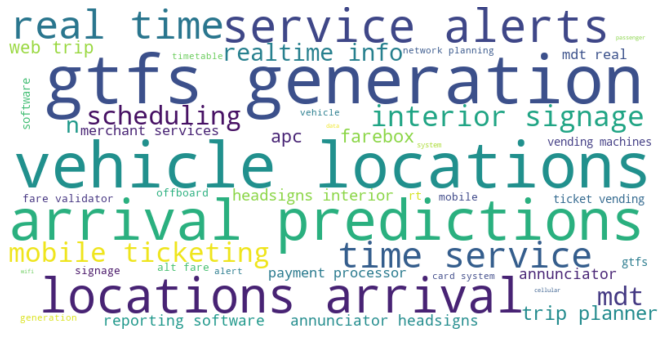

In [58]:
word_cloud_gen(elements_only)

### Most popular vendors by contract awarded

In [59]:
vendors2 = (
    contracts.contract_vendor.value_counts()
    .to_frame()
    .reset_index()
    .head(10)
    .rename(columns={"index": "vendor", "contract_vendor": "number_of_contracts"})
)

In [60]:
bar_chart(vendors2, "number_of_contracts", "vendor")

alt.Chart(...)

### Organizations that hold the most contracts

In [61]:
contract_holders = (
    contracts.contract_holder.value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={"index": "holders", "contract_holder": "# contracts"})
    .head(10)
)

In [62]:
bar_chart(contract_holders, "# contracts", "holders")

alt.Chart(...)

### Looking at contracts and their elements with end dates from now to 2024.
* Of the contracts ending, most have an element of vehicle locations and arrival predictions.
* 

In [65]:
end_dates = contracts2.dropna(subset=["end_date"])

In [66]:
end_dates = end_dates.assign(
    start_date=pd.to_datetime(contracts.start_date, errors="coerce"),
    end_date=pd.to_datetime(contracts.end_date, errors="coerce"),
)

In [67]:
end_dates.shape

(342, 11)

In [68]:
end_dates.end_date.describe()

/tmp/ipykernel_598/3580204313.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  end_dates.end_date.describe()


count                      99
unique                     33
top       2021-04-18 00:00:00
freq                       10
first     2010-09-21 00:00:00
last      2024-06-30 00:00:00
Name: end_date, dtype: object

In [69]:
# Keep only end dates from now until 2024.
end_dates = end_dates.loc[
    (end_dates["end_date"] >= "2022-05-03") & (end_dates["end_date"] < "2024-12-31")
]

In [70]:
end_dates.contract_type_use.value_counts().head()

Vehicle Locations           5
Arrival predictions         5
Realtime info               4
Real-time service alerts    4
Interior signage            3
Name: contract_type_use, dtype: int64

In [71]:
end_dates = end_dates.groupby(["contract_type_use", "end_date", "contract_holder"]).agg(
    {"duration_of_contract_year": "max"}
)

In [72]:
end_dates

duration_of_contract_year
contract_type_use        end_date   contract_holder                                                   
Annunciator              2023-11-28 Santa Cruz Metropolitan Transit District                      5.00
                         2024-06-30 Monterey-Salinas Transit                                      5.17
Arrival predictions      2022-05-03 Redwood Coast Transit Authority                               3.00
                         2023-05-07 Tuolumne County Transit Agency                                4.00
                         2023-11-06 Yuba-Sutter Transit Authority                                 5.00
                         2023-11-28 Santa Cruz Metropolitan Transit District                      5.00
                         2024-06-30 Monterey-Salinas Transit                                      5.17
GTFS Generation          2022-07-31 Trinity County                                                3.00
Headsigns                2023-11-06 Yuba-Sutter Transit Authority                                 5.00
                         2023-11-28 Santa Cruz Metropolitan Transit District                      5.00
Interior signage         2023-11-06 Yuba-Sutter Transit Authority                                 5.00
                         2023-11-28 Santa Cruz Metropolitan Transit District                      5.00
                         2024-06-30 Monterey-Salinas Transit                                      5.17
MDT                      2023-05-07 Tuolumne County Transit Agency                                4.00
                         2023-11-28 Santa Cruz Metropolitan Transit District                      5.00
                         2024-06-30 Monterey-Salinas Transit                                      5.17
N/A                      2022-05-05 N/A                                                            N/A
Offboard signage         2024-06-30 Monterey-Salinas Transit                                      5.17
Real-time service alerts 2022-05-03 Redwood Coast Transit Authority                               3.00
                         2023-05-07 Tuolumne County Transit Agency                                4.00
                         2023-11-28 Santa Cruz Metropolitan Transit District                      5.00
                         2024-06-30 Monterey-Salinas Transit                                      5.17
Realtime info            2022-05-03 Redwood Coast Transit Authority                               3.00
                         2022-05-17 Anaheim Transportation Network                                5.00
                         2023-05-07 Tuolumne County Transit Agency                                4.00
                         2023-11-28 Santa Cruz Metropolitan Transit District                      5.00
Scheduling               2024-06-30 Marin County Transit District                                 5.00
Vehicle Locations        2022-05-03 Redwood Coast Transit Authority                               3.00
                         2023-05-07 Tuolumne County Transit Agency                                4.00
                         2023-11-06 Yuba-Sutter Transit Authority                                 5.00
                         2023-11-28 Santa Cruz Metropolitan Transit District                      5.00
                         2024-06-30 Monterey-Salinas Transit                                      5.17
Web trip planner         2022-07-31 Trinity County                                                3.00
                         2023-05-07 Tuolumne County Transit Agency                                4.00

## Export

In [73]:
'''
with pd.ExcelWriter(f"./Cleaned_Transit_Stacks.xlsx") as writer:
    products.to_excel(writer, sheet_name="products_clean", index=False)
    popular_products.to_excel(writer, sheet_name="popular_products", index=False)
    components.to_excel(writer, sheet_name="components_clean", index=False)
    contracts.to_excel(writer, sheet_name="contracts_clean", index=False)
    contracts2.to_excel(writer, sheet_name="contracts_delineated", index=False)
    '''